In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from net import NormalNetwork, PCANetwork, train_network, test_network
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from data import get_mnist_pca, precompute_mnist_params, get_mnist_raw
from graph import show_image_list
from collections import defaultdict

thresh_list = list(reversed([0.25, 0.5, 0.75, 0.9, 0.95]))
N = 4

pca = precompute_mnist_params()['pca']
normal_images = [im.numpy().reshape((28, 28)) for im in next(iter(get_mnist_raw(train=False)))[0][:N]]

images = defaultdict(list)
for i, im in enumerate(normal_images):
    images[i].append(im)
for thresh in thresh_list:
    pca_images = next(iter(get_mnist_pca(train=False, pca_thresh=thresh)))
    for i, im in zip(range(N), pca_images[0]):
        images[i].append(pca.get_reconstructed_image(im.numpy(), thresh).reshape((28, 28)))

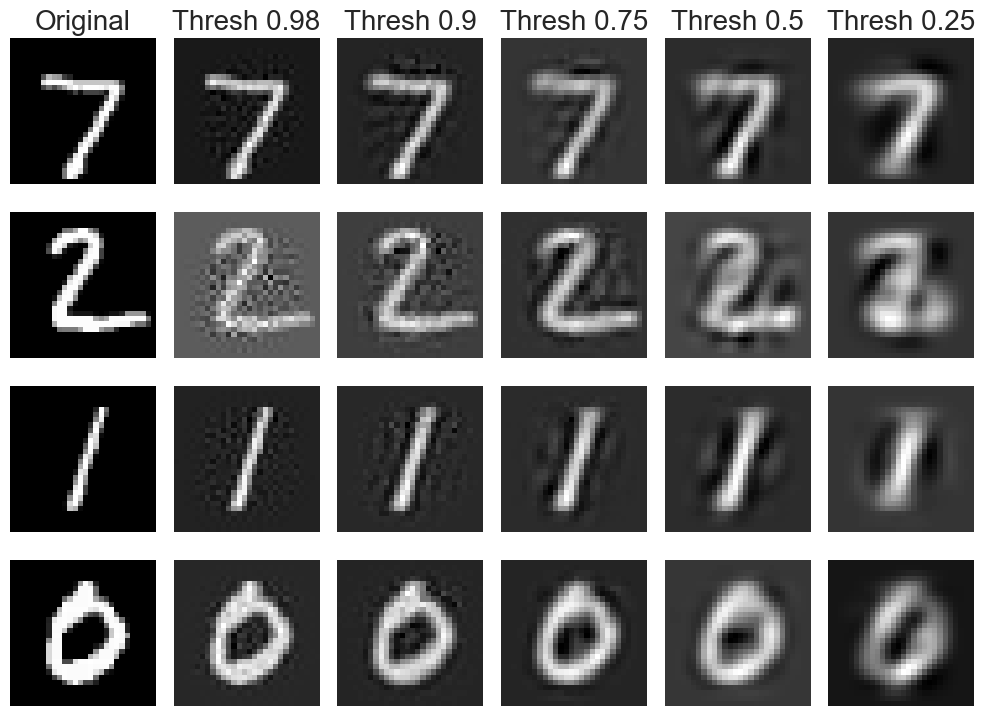

In [3]:
show_image_list(
    sum(images.values(), []), 
    ['Original'] + list(map(lambda x: f'Thresh {x}', thresh_list)) + [None] * ((N-1) * (len(thresh_list)+1)), 
    num_cols=len(thresh_list)+1, 
    figsize=(10, 7.5), 
    title_fontsize=20
)

#### Train with MNIST dataset

In [14]:
model = NormalNetwork(unpack_data=True)
model

NormalNetwork(
  (forward_prob): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
  (loss_func): CrossEntropyLoss()
)

In [3]:
train_network(model)

Training epoch 20: 100%|██████████| 1875/1875 [00:00<00:00, 2077.26it/s]


#### Test with MNIST dataset

In [4]:
res = test_network(model)
print(res)

Testing network: 100%|██████████| 313/313 [00:00<00:00, 3277.83it/s]

{'accuracy': 0.9781, 'loss': 0.06678009927492702, 'confusion matrix': array([[ 970,    0,    2,    2,    1,    3,    0,    1,    1,    0],
       [   0, 1125,    3,    1,    0,    1,    2,    0,    3,    0],
       [   4,    2, 1014,    2,    1,    0,    2,    3,    4,    0],
       [   0,    0,    6,  992,    0,    3,    0,    2,    1,    6],
       [   1,    0,    4,    1,  966,    0,    1,    1,    0,    8],
       [   2,    0,    0,    5,    1,  874,    4,    0,    2,    4],
       [   6,    3,    1,    1,    6,   11,  928,    1,    1,    0],
       [   2,    5,   11,    2,    5,    0,    0,  989,    2,   12],
       [   5,    0,    5,    4,    4,    7,    4,    2,  939,    4],
       [   4,    2,    0,    5,    7,    4,    0,    2,    1,  984]])}


#### Plot confusion matrix

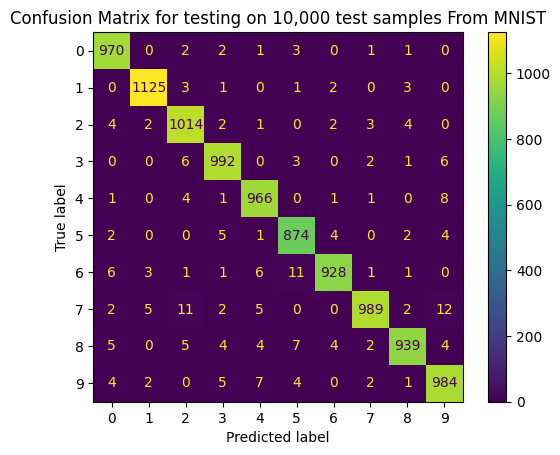

In [5]:
disp = ConfusionMatrixDisplay(confusion_matrix= res["confusion matrix"])
disp.plot()
plt.title("Confusion Matrix for testing on 10,000 test samples From MNIST")
plt.show()

#### Train with PCA data

In [6]:
model = PCANetwork(0.95, unpack_data=True)
model

PCANetwork(
  (forward_prob): Sequential(
    (0): Linear(in_features=331, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (loss_func): CrossEntropyLoss()
)

In [7]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

60298

In [8]:
train_network(model)

Training epoch 20: 100%|██████████| 1875/1875 [00:00<00:00, 3300.46it/s]


In [9]:
res = test_network(model)
print(res)

Testing network: 100%|██████████| 313/313 [00:00<00:00, 4660.52it/s]

{'accuracy': 0.9742, 'loss': 0.09707158432298782, 'confusion matrix': array([[ 972,    0,    1,    1,    0,    1,    1,    1,    3,    0],
       [   0, 1125,    3,    1,    0,    1,    2,    0,    3,    0],
       [   5,    3, 1004,    2,    2,    0,    1,    6,    9,    0],
       [   0,    0,    3,  989,    0,    5,    0,    4,    5,    4],
       [   0,    0,    9,    1,  954,    1,    3,    4,    1,    9],
       [   2,    0,    0,   11,    2,  866,    2,    2,    4,    3],
       [   6,    3,    3,    1,    6,    8,  930,    0,    1,    0],
       [   1,    7,    7,    0,    3,    0,    0,  998,    1,   11],
       [   4,    1,    3,    8,    4,    7,    3,    3,  934,    7],
       [   3,    3,    2,    6,   14,    4,    0,    5,    2,  970]])}


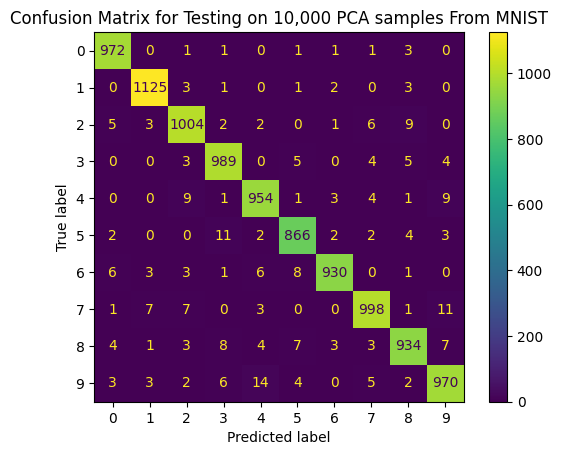

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=res["confusion matrix"])
disp.plot()
plt.title("Confusion Matrix for Testing on 10,000 PCA samples From MNIST")
plt.show()

In [11]:
from graph import draw_metric_graph, draw_time_graph

Initializing networks...


Testing network: 100%|██████████| 313/313 [00:00<00:00, 4226.26it/s]


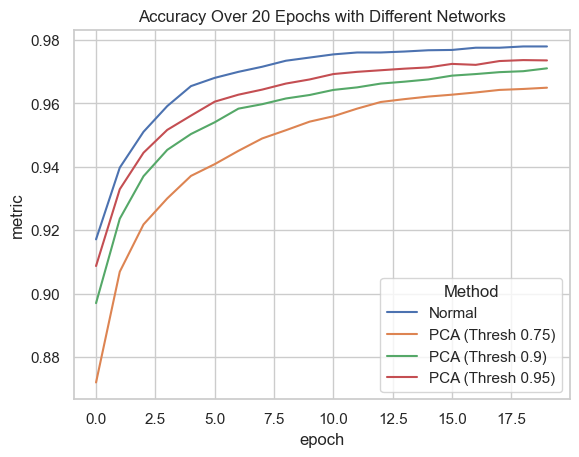

In [12]:
draw_metric_graph(pca_thresh=[0.75, 0.90, 0.95], epochs=20)

Training epoch 10: 100%|██████████| 1875/1875 [00:00<00:00, 4703.97it/s]


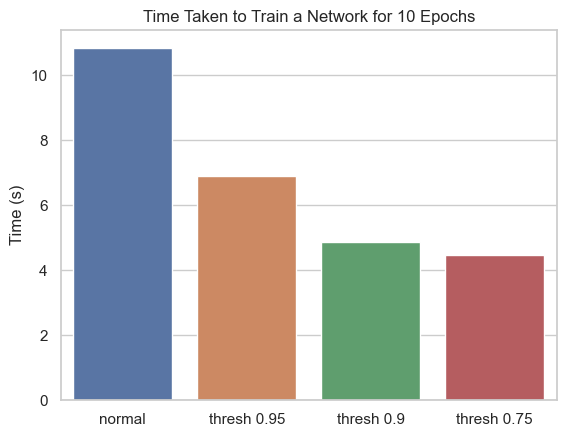

In [13]:
draw_time_graph(pca_thresh=[0.95, 0.90, 0.75], epochs=10)